# Create flying node graph
This Notebook will create the graph we will use for flying our drone. We do it once so we don't have to do it everytime we load the simulator.

## Imports

In [1]:
import networkx as nx
nx.__version__

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from planning_utils import heuristic, create_grid, FLYING_ALTITUDE, SAFETY_DISTANCE
import time

%matplotlib inline

## Load Data

In [2]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


# Random sampling method

In [3]:
from sampling import Sampler

print('Sampling')
t0 = time.time()
sampler = Sampler(data, FLYING_ALTITUDE, FLYING_ALTITUDE+SAFETY_DISTANCE)
polygons = sampler.polygons

nodes = sampler.sample(3000)
print('Sampling took {0} for {1}'.format(time.time()-t0, len(nodes)))

Sampling
Sampling took 0.4823126792907715 for 2271


In [4]:
# Create a grid map of the world
grid, _, north_offset, east_offset = create_grid(data, FLYING_ALTITUDE, SAFETY_DISTANCE)

## Create the graph by connecting the Nodes

In [5]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
    
import numpy.linalg as LA
from sklearn.neighbors import KDTree

def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                dist = LA.norm(np.array(n2) - np.array(n1))
                g.add_edge(n1, n2, weight=dist)
    return g

print('Creating Graph')
t0 = time.time()
g = create_graph(nodes, 10)
print('Graph took {0} seconds to build'.format(time.time()-t0))

Creating Graph
Graph took 454.8669271469116 seconds to build


## Save to pickle

In [7]:
from utils import save_graph_to_pickle

save_graph_to_pickle(g, grid, north_offset, east_offset, 'graph.random_sampling.raw.p')

print('done')

Saving to pickle file graph.random_sampling.raw.p
done


## Visualize Graph

In [10]:
from utils import visualize_graph, print_info

print_info(g, grid, north_offset, east_offset)

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

visualize_graph(g, grid, north_offset, east_offset)

print('done')

Graph nodes:  2253
Graph edges: 11066
Grid dimensions (921, 921), north_offset: -316, east_offset: -445 


TypeError: from_bounds() argument after * must be an iterable, not int

## A*

Start:  1143
Goal:  1805
Found a path.
27 [(-181.5232044768752, 374.6415309223522, 10.542286736013569), (-173.10045834934692, 336.08043410982236, 18.09078654857731), (-146.03940925791716, 318.7247793113223, 7.9910742795004825), (-124.655972384866, 258.9932916593083, 9.752794376251948), (-127.63725512830806, 244.410561974448, 7.278565623397064), (-137.8299131650578, 209.42018448068666, 18.32856663081657), (-158.78027833029824, 178.11880852902664, 13.165389353659442), (-152.30682773265522, 146.1194321622047, 11.691637028006571), (-119.06763645410223, 112.94491212749915, 5.358731965785881), (-128.60083376921597, 73.17060716483763, 18.813733061725358), (-122.8742376467469, 34.91919203552743, 8.154515233767226), (-153.50219078221627, 2.256207186396864, 0.5552364210468985), (-177.91349778702732, -36.153183107108305, 7.993096825981791), (-149.8964202802318, -59.12617865032445, 3.8666988764044397), (-118.75546324560261, -84.09608156514514, 8.746290064334305), (-112.56849333365847, -114.6937685

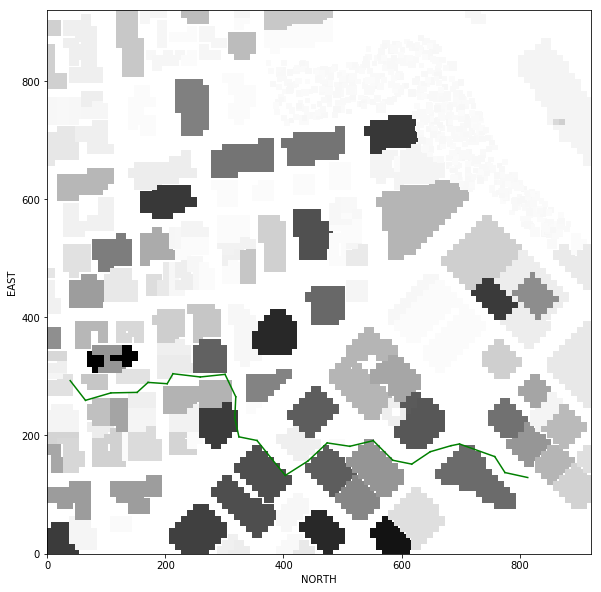

...done


In [34]:
from utils import perform_astar

perform_astar(g, grid)

print('done')